The document is contributed by PeiJie, Thanks.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from utils import Dataset, AbcClassifier, VisDecision
np.random.seed(42)

## Kernel Trick


Let's recap the feature transformation from <b>Lecture 3</b> regarding polynomial feature transformation where we compute the explicit polynomial feature transformations. For instance, we have $x \in \mathbb{R}^{d}$ and a polynomial transformation function $\phi(x)=[1, x_1, \dots, x_d , \dots, x_1 x_2, \dots, x_1 x_2\dots x_d]$, what is the dimensionality of the transfered feature space $D$ of $\phi(x)$ ? The answer is $D=2^d$. <b>(Figure out why !)</b> The dimensionality of the transfered feature space growes exponentially w.r.t. the original dimensionality. (<b>Isn't that expensive ?</b> e.g., d=100, what is D ?) The curse of dimensionlity is the biggest problem in explicit feature transformation in terms of computation ! In realiity, we always have limited computational resource (e.g., 32G memory).  
<p>
This leads us to think whether there is a way to achieve (Non-Linear) feature transformation with reasonable dimensionlity cost. The idea is simple-discard the explicit feature transformation but doing implicit feature transformation (Kernel trick).
We linearize the entire ML algorithm with this kernel trick to achieve complicated feature transformation implicitly. 
<p>
Let's go from the simplest case-Linear Model (we will see the SVM in the next lecture). 


## Manifold Trick
<p>
<font size="3">
    In this case, the data is not linearly separable meaning we cannot find a 2-dimensional hyperplane (not a single line but a set of lines) that can perfectly separate those two categories. <b> How to prove it mathmatically?</b> But we can more appreciate the terminology of <b> Manifold</b>. Just open up your imagination of the geometry! a set of linearly non-separable points in 2-dimensional might be linearly separable in a more high-dimensional space/manifold. E.g., a 2D manifold can be viewed as the projection of any 3D or higher-dimensional manifold.
</font>    

In [3]:
n_samples = 500
n_features = 2
n_classes = 2
noise = 0.05
seed = 2
X, y = Dataset('circle').make(n_samples, n_features, n_classes, noise, seed)
X[:, [1, 0]] = X[:, [0, 1]]

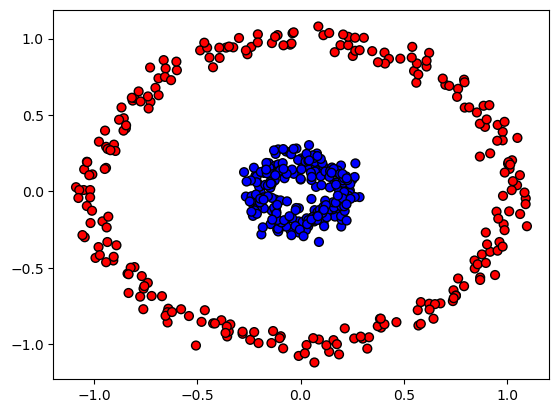

In [4]:
plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap=ListedColormap(["#FF0000", "#0000FF"]), edgecolors="k")

In [5]:
def feature_map_1(X):
    return np.asarray((X[:,0], X[:,1], X[:,0]**2 + X[:,1]**2)).T

def feature_map_2(X):  
    return np.asarray((X[:,0], X[:,1], np.exp( -( X[:,0]**2 + X[:,1]**2)))).T

def feature_map_3(X):  
    return np.asarray((np.sqrt(2) *X[:,0] * X[:,1], X[:,0]**2, X[:,1]**2)).T

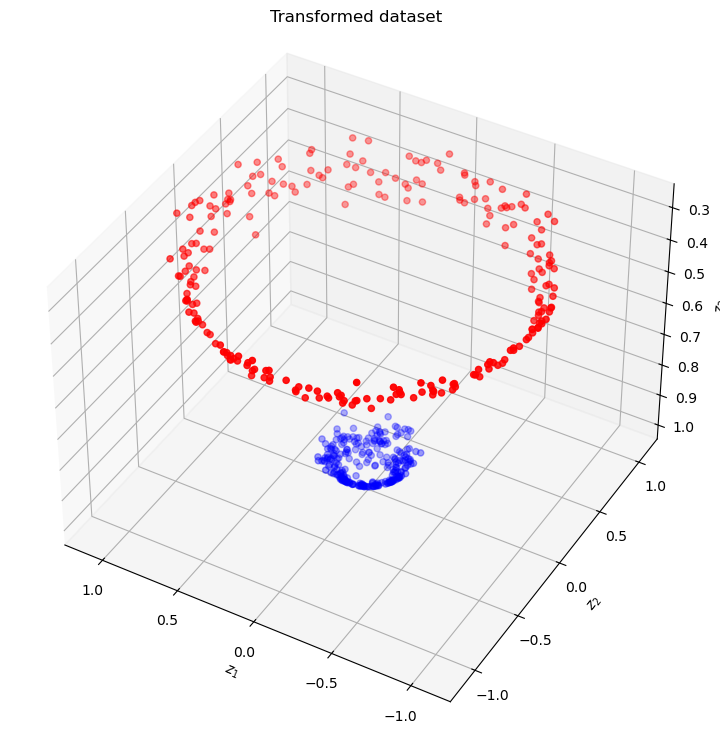

In [6]:
Z = feature_map_2(X)
#3D scatter plot
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter3D(Z[:,0],Z[:,1], Z[:,2],c = y, cmap=ListedColormap(["#FF0000", "#0000FF"]))
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
ax.set_title('Transformed dataset')

ax.view_init(-140, 60)

### Kernelized Linear Model
Linear model is defined as $h(x)=w^T x$. Gradient descent with a squared loss function:
$[\mathcal{L}(w) = \sum_{i=1}^{n}(w^T x_i -y_i)^2]$
Then the gradient w.r.t. $w$ is 
$[g(w)=\frac{\partial \mathcal{L}(w)}{\partial w}=\sum_{i=1}^{n}2(w^T x_i -y_i)x_i]$
Recall gradient descent update rule:
$begin{align}
    w_{t+1} &= w_t - s g(w_t) 
$end{align}
We prove that $w_t$ is a linear combination of $x_i$ by induction: 
    1. $w_0$ is initialized as 0, as $\mathcal{L}(w)$ is convex, then the solution is independent of the initialization.
        $[w_1 = \sum_{i=1}^{n} 2s y_i x_i = \sum_{i=1}^{n} \alpha_i^{(0)} x_i  ]$
    2. Assume $w_t = \sum_{i=1}^{n} \alpha_i^{(t)} x_i $, we get

$
    \begin{align}
    w_{t+1} &= w_t - s g(w_t) \\
            &= \sum_{i=1}^{n} \alpha_i^{(t)} x_i - s \sum_{i=1}^{n} 2 (w_t^{T} x_i - y_i) x_i \\
            &= \sum_{i=1}^{n} \alpha_i^{(t+1)} x_i, \quad (\alpha_i^{(t+1)} = \alpha_i^{(t)} - 2s(w_t^T x_i - y_i) x_i)
    \end{align}
$

As $w_t$ can be written as a linear combination of $x_i$, we do not need to care about the explicit expression of $w_t$. Instead, we update $\alpha_i^{(t)}$ for each iteration.
    Let's continue this trick ! 

$
    \begin{align}h_t(x_i) 
    &= w_t^T x_i \\
    &= \sum_{j=1}^{n}\alpha_j^{(t)}x_j^T x_i, \ (w_t = \sum_{j=1}^{n} \alpha_j^{(t)} x_j)
    \end{align}
$
Now, we do not need evulate $w$ any more. Instead, we can do gradient descent in terms of $x_j^Tx_i$ to evaluate $\alpha_i^{(t)}$. Note that $x_j^Tx_i$ is the inner product of the training set which can be pre-computed meaning we do not need to compute $x_j^Tx_i$ for each iteration. Instead, we store the inner product $x_j^Tx_i$ as a $n\times n$ kernel matrix $K$ where $K_{ij}=<\phi(x_i), \phi(x_j)>$, $<|.|>$ denotes inner product $\phi(x_i)^{T} \phi(x_j)$ and $\phi(x)=x$ at this time. This is also called a linear kernel, as the kernel function $k(x, x') = <\phi(x), \phi(x')> = x^T x'$ is linear at this point.
    

<b> Why do we do this ? </b>
Let's see the polynomial regression again. we plug $\phi(x_i)=[1, x_{i1}, \dots, x_{id} , \dots, x_{i1} x_{i2}, \dots, x_{i1} x_{i2}\dots x_{id}]^T$ into the above equation:

$
     \begin{align}
        <\phi(x_i), \phi(x_j')> &= \phi(x_i)^T \phi(x_j') \\
                  &= 1*1 + x_{i1} x_{j1}' + \dots +x_{i1}x_{i2}x_{j1}'x_{j2}'+\dots + x_{i1}x_{i2}\dots x_{id} x_{j1}'x_{j2}'\dots x_{jd}' \\
                  &= \prod_{k=1}^{d}(1+x_{ik}x_{jk'})
    \end{align}
$    
Then the kernel function $k(x, x') = (1+x^T x)^d$ where $d$ is the degree of the polynomial. This takes $O(d)$ time and $O(n^2)$ space to compute. The explicit feature transformation takes $O(2^d)$ time and $O(2^d)$ space to compute. See the advantages ! Notice that all the kernel matrix $K$ can be computed in advance ! 

### Let's see a concrete example !
<p>
Instead of $2^{nd}$ order polynomial regression, we do a higher order $10^{th}$ order polynomial regression with this kernel trick ! Recall that the kernel matrix $K$ is computed as $k(x, x') = (1+x^T x)^d$ where $d$ is the degree of the polynomial.

In [10]:
class KernelClassifier(AbcClassifier):
    def __init__(self, kernel_type, kpar=None):
        super().__init__()
        self.kernel_type = kernel_type
        self.kpar = kpar
        
    def fit(self, X, y):
        X, y = super().fit(X, y)
        n, d = X.shape
        X = np.hstack((X, np.ones((n, 1))))
        y = y.reshape(-1, 1)
        
        # your code here 
        # Initialize the parameters to be estimated 
        alpha_init = np.zeros((X.shape[0], 1))
        
        # Compute the kernel matrix K first
        self.X_ = X
        K = self.computeK(X, X)
        
        # Use whatever method to solve the Linear model to estimate alpha
        self.alpha_ = np.linalg.pinv(K.T.dot(K)).dot(K.T).dot(y)
        
        return self
    
    def predict(self, X):
        X = super().predict(X)
        
        n, d = X.shape
        X = np.hstack((X, np.ones((n, 1))))
        
        # your code here
        # Compute the kernel matrix K first
        K = self.computeK(X, self.X_)
        y_pred = np.sign(K.dot(self.alpha_))
        
        return y_pred.squeeze()


    def computeK(self, X, Z):
        """
        INPUT:
        X : nxd input data
        Z: nxd input data
        order: the degrees of polynomials  

        Output:
        The kernel matrix K
        """
        n, d = X.shape
        m, dd = Z.shape
        assert d == dd, 'First dimension of X and Z must be equal in input to computeK'

        K = np.zeros((n, m))
        # your code here
        if self.kernel_type  == 'linear':
            K = X.dot(Z.T) # your code here 
        elif self.kernel_type == 'poly':
            K = (1 + X.dot(Z.T)) ** self.kpar # your code here 
        elif self.kernel_type == 'other':
            K = feature_map_3(X).dot(feature_map_3(Z).T)

        return K

二分类问题是y真值为-1和1，然后基于x回归出线性模型ax+b=0的线性模型是不是就可以根据线性模型取sign就能进行二分类？
回答：可以基于线性模型回归一个二分类模型，但其对label的准确性要求更高，和逻辑回归算法有实现上的不同。逻辑回归对异常值相对不敏感。

In [11]:
clf = KernelClassifier('poly', 2).fit(X, y)

### Visualization your decision boundary

<Axes: title={'center': 'Decision Boundary'}, xlabel='X1', ylabel='X2'>

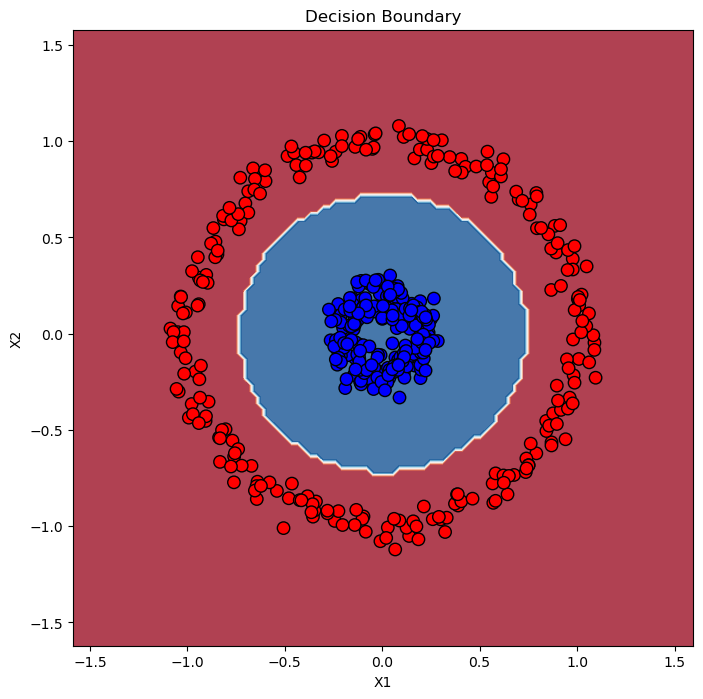

: 

In [12]:
VisDecision(clf).plot(X, clf.predict(X))

### Solution

In [18]:
class KernelClassifier(AbcClassifier):
    def __init__(self, kernel_type, kpar=None):
        super().__init__()
        self.kernel_type = kernel_type
        self.kpar = kpar
        
    def fit(self, X, y):
        X, y = super().fit(X, y)
        n, d = X.shape
        X = np.hstack((X, np.ones((n, 1))))
        y = y.reshape(-1, 1)
        
        # your code here 
        # Initialize the parameters to be estimated 
        alpha_init = np.zeros((X.shape[0], 1))
        
        # Compute the kernel matrix K first
        self.X_ = X
        K_ = self.computeK(X, X)
        
        self.alpha_ = np.linalg.pinv(K_.T.dot(K_)).dot(K_.T).dot(y)
        
        # Return the classifier
        return self
    
    def predict(self, X):
        X = super().predict(X)
        
        n, d = X.shape
        X = np.hstack((X, np.ones((n, 1))))
        
        # your code here
        # Compute the kernel matrix K first
        K = self.computeK(X, self.X_)
        y_pred = np.sign(K.dot(self.alpha_))
        
        return y_pred.squeeze()


    def computeK(self, X, Z):
        """
        INPUT:
        X : nxd input data
        Z: nxd input data
        order: the degrees of polynomials  

        Output:
        The kernel matrix K
        """
        n, d = X.shape
        m, dd = Z.shape
        assert d == dd, 'First dimension of X and Z must be equal in input to computeK'

        K = np.zeros((n, m))
        # your code here
        if self.kernel_type  == 'linear':
            K = X.dot(Z.T)
        elif self.kernel_type == 'poly':
            K = (1 + X.dot(Z.T)) ** self.kpar
        elif self.kernel_type == 'rbf':
            K = np.exp(-self.kpar * (self.l2distance(X, Z) ** 2))
        elif self.kernel_type == 'own':
            K = feature_map_3(X).dot(feature_map_3(Z).T)

        return K
    
    def l2distance(self, X, Z):
        n, d = X.shape
        k, dd = Z.shape
        assert d == dd, 'First dimension of X and Z must be equal in input to l2distance'

        D = np.zeros((n, k))
        
        ## your code here 
        S = np.sum(X ** 2, axis=-1).reshape((-1, 1))
        R = np.sum(Z ** 2, axis=-1).reshape((1, -1)) 
        
        G = X.dot(Z.T)
        
        D = S - 2 * G + R

        # solve numerical instability
        D = np.maximum(D, 0)
        D = np.sqrt(D)

        return D